<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/binario/FL/Binario_FL_efficientnet_b3_BalanceoSklearn_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=550a08945499aa9ff119547dc4aefbbeec0e5dbf&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f77616c6b776974686661737461692f77616c6b776974686661737461692e6769746875622e696f2f353530613038393435343939616139666631313935343764633461656662626565633065356462662f6e62732f30325f766973696f6e2e65787465726e616c2e74696d6d2e6970796e62&logged_in=false&nwo=walkwithfastai%2Fwalkwithfastai.github.io&path=nbs%2F02_vision.external.timm.ipynb&platform=android&repository_id=295613905&repository_type=Repository&version=98

En este cuaderno probaremos la arquitectura efficientnet_b3 para ver si obtenemos unos mejores resultados.

## Efficientnet_b3 con Balanceo Sklearn

In [1]:
!pip install fastai -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 214 kB 30.5 MB/s 
     |████████████████████████████████| 61 kB 8.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 29.0 MB/s 


{'restart': True, 'status': 'ok'}

In [1]:
!pip install wwf -q
# !pip install nbdev

In [22]:
from fastai.vision.all import *

import timm
from wwf.utils import *
from wwf.vision.timm import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [3]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-07-01 07:53:36 URL:https://uc06fc5a8680bcc7ac85590a4186.dl.dropboxusercontent.com/cd/0/inline2/BoN2EgBrz6nFhI-IEb-W9LM4IR1_ACzaoanoD_ChbxP5Cdtac2YV9TuNC0kYj5tAanHun6_WySQu0qowK2Gjbl0IRjH5qkDQ5WPgXHJPRcNMTrhJq5tcCwygYrykdY4IHKzvV5vi72XdfIS6u0GudqNtr0XS44D89CRNBD6F_qxSvdCbEGmWS4Ze9-6cSEd-cJvDrxJyVk6k5boHe9mwtuasnILzZ7MAWHztwRGgl6hzNYe_j0IYz0YbhunuO3b69-JUck-R8Qxs_pa8LPpuCR7HPJHj3qMEBpvQhxt84EGgFhL_jXDdSsSO-y0ySPBwLw08-Pgk-C06TfAj1ev7veCD-Z_BbXMCr4vpC_ya7-cxu7QtBQL-0-YfG7p00Id5Z7ugrjk3B1GD1FIm317lOKhSS_fHZn0kjsDdVFSMFaJGuA/file [138777773/138777773] -> "train.zip" [1]
2022-07-01 07:53:42 URL:https://uc89073572027ae9a9d05bf059e3.dl.dropboxusercontent.com/cd/0/inline2/BoPa7c0qLwRasarMH_rQMdF3UAS41W2WghmeVuVmzRWe2Aglv5bRglyRDj3nlxbYLiTAPY12N8XyXuBC1rfPwdt_OV9BYxPGGcig2hlhBKYNuZhMvKbIT5A5721wYllfGQH2wxXJ4wAtzei-whU6Gg6OvD1jxMtr-UkYcq-C-S4fIAsyVlv27EObcvbJH2thEb16i0o07c8Ta7aBEvX52Tcd6_mNcwRNjeUXbqTuaRECksMrgOa9iEzgMOZI8r-EicEar5W91lQ1a1BkMHM6du-vwo2JEE71YdsJTM-TNvg_lSiwyIYqwkd_WpzAbx7ZnIW

In [4]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [5]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [6]:
crearEstructura('dataset', ['normal', 'enfermedad'])

In [7]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [8]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

#### Mover imágenes:

In [9]:
import shutil
import uuid

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.copy(pathO + '/' + str(id) + '.png', pathD + '/normal/' + str(uuid.uuid1()) + '.png')
    else:
        shutil.copy(pathO + str(id) + '.png', pathD + '/enfermedad/' + str(uuid.uuid1()) + '.png')

In [10]:
path = Path('dataset')

## Balanceo

In [11]:
from sklearn.utils import resample

In [12]:
df_majority = df_train[df_train.Disease_Risk==1] #mayoria de instacias con enfermedad respecto a sin ella.
df_minority = df_train[df_train.Disease_Risk==0]

In [13]:
# Aumentar la muestra de la clase minoritaria
# Aumentar la muestra de la clase minoritaria
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # muestra con remplazamiento
                                 n_samples=960,    # número de muestras de la clase mayoritaria
                                 random_state=42) # semilla para que los resultados sean reproducibles

# Disminuir la clase mayoritaria
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # muestra sin remplazamiento
                                 n_samples=960,     # número de muestras de la clase minoritaria
                                 random_state=42) # semilla para que los datos sean reproducibles
                               
# Combinar el nuevo grupo con el grupo original mayoritario
df_train = pd.concat([df_majority_downsampled, df_minority_upsampled])
df_train = df_train.reset_index(drop=True)

# Mostrar el número de instancias en cada clase
df_train.Disease_Risk.value_counts()

1    960
0    960
Name: Disease_Risk, dtype: int64

In [14]:
len(df_minority_upsampled.ID.unique())

359

**Una vez que tenemos el dataframe balanceado comenzamos a copiar las imágenes a las carpetas que corresponda.**

In [15]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

## Cargando el dataset

In [16]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [17]:
dls = db.dataloaders(path,bs=128)

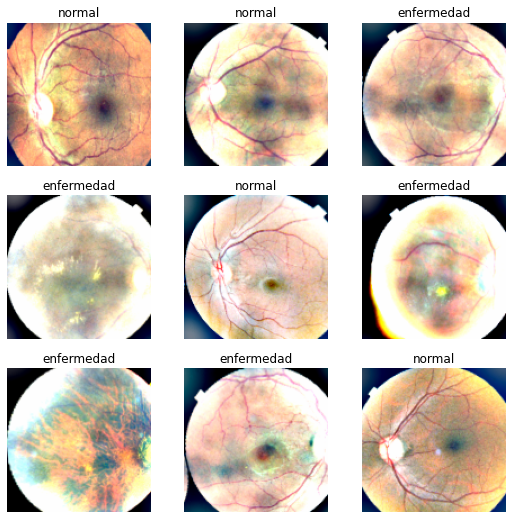

In [18]:
dls.show_batch()

In [19]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback()
]

In [82]:
metrics = [ accuracy, Precision(), Recall(), F1Score() ]
learn = timm_learner(dls, 'efficientnet_b3', metrics=metrics, loss_func=FocalLoss(), cbs=callbacks).to_fp16()

SuggestedLRs(minimum=0.00831763744354248, steep=0.0003311311302240938, valley=0.0012022644514217973, slide=0.005248074419796467)

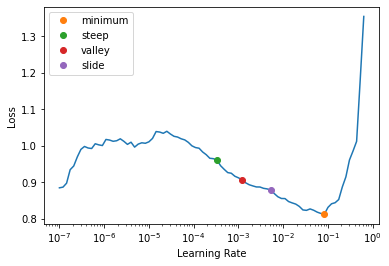

In [83]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.878447,0.468667,0.726562,0.415638,0.753731,0.535809,00:10


Better model found at epoch 0 with valid_loss value: 0.4686669707298279.


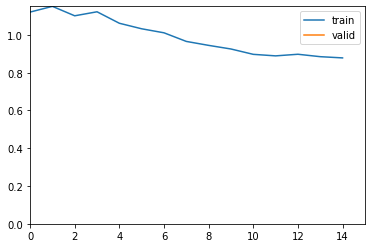

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.704863,0.410737,0.739062,0.431535,0.776119,0.554667,00:12
1,0.648351,0.438156,0.720312,0.405858,0.723881,0.520107,00:10
2,0.647136,0.383889,0.729688,0.419087,0.753731,0.538667,00:10
3,0.625917,0.333230,0.760938,0.455399,0.723881,0.559078,00:11
4,0.591730,0.325071,0.751562,0.443439,0.731343,0.552113,00:10
5,0.579060,0.310999,0.751562,0.448133,0.805970,0.576000,00:10
6,0.560564,0.278268,0.770312,0.469767,0.753731,0.578797,00:10
7,0.540604,0.291954,0.751562,0.444444,0.746269,0.557103,00:10
8,0.518967,0.300574,0.742188,0.435146,0.776119,0.557641,00:10
9,0.508659,0.259154,0.770312,0.471861,0.813433,0.597260,00:10


Better model found at epoch 0 with valid_loss value: 0.41073742508888245.


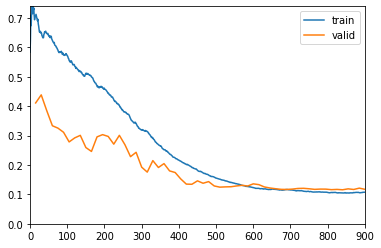

Better model found at epoch 2 with valid_loss value: 0.38388875126838684.
Better model found at epoch 3 with valid_loss value: 0.3332304358482361.
Better model found at epoch 4 with valid_loss value: 0.325070858001709.
Better model found at epoch 5 with valid_loss value: 0.31099933385849.
Better model found at epoch 6 with valid_loss value: 0.27826815843582153.
Better model found at epoch 9 with valid_loss value: 0.25915437936782837.
Better model found at epoch 10 with valid_loss value: 0.24590840935707092.
Better model found at epoch 17 with valid_loss value: 0.22821426391601562.
Better model found at epoch 19 with valid_loss value: 0.19243720173835754.
Better model found at epoch 20 with valid_loss value: 0.1756855547428131.
Better model found at epoch 25 with valid_loss value: 0.17426428198814392.
Better model found at epoch 26 with valid_loss value: 0.1525265872478485.
Better model found at epoch 27 with valid_loss value: 0.13487079739570618.
Better model found at epoch 28 with val

In [84]:
%%time
learn.fine_tune(60,base_lr=1e-3)

## Evaluando el Modelo

In [85]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [86]:
learn.dls = dlsTest

In [87]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7437499761581421.


(#5) [0.14324244856834412,0.7437499761581421,0.44525547445255476,0.9104477611940298,0.5980392156862745]

Exportamos el modelo:

In [88]:
learn.to_fp32()
learn.export('Binario_FL_efficientnet_b3_BalanceoSklearn.pkl')

## Interpretación del modelo


/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:275: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


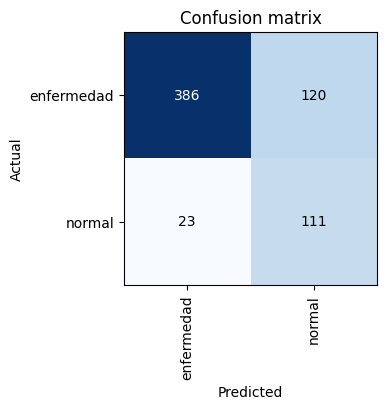

In [89]:
learn_inf = load_learner('Binario_FL_efficientnet_b3_BalanceoSklearn.pkl')
learnInterp = cnn_learner(dls,resnet18).to_fp16()
learnInterp.model = learn_inf.model
interp = ClassificationInterpretation.from_learner(learnInterp)
interp.plot_confusion_matrix(figsize=(4,4),dpi=100)

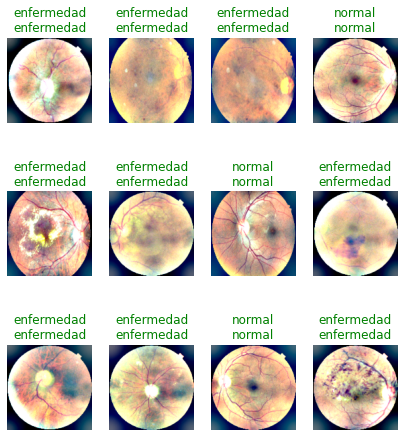

In [90]:
learnInterp.show_results(max_n=12, figsize=(7,8))